Goal: convert avi to some kind of numpy array
============

In [1]:
import cv2.cv as cv
import cv2

In [2]:
import numpy as np

# capture = cv.CaptureFromFile('videotest.avi')
# frames = []
# for i in xrange(200):
#     img = cv.QueryFrame(capture)
#     if img==None: break
# #     print type(img)
# #     tmp = cv.CreateImage(cv.GetSize(img),8,3)
# #     cv.CvtColor(img,tmp,cv.CV_BGR2RGB)
#     tmp = img
#     frames.append(np.asarray(cv.GetMat(tmp))) 
# frames = np.array(frames)


try:
    vidFile = cv2.VideoCapture('videotest.avi')
except:
    print "problem opening input stream"
    sys.exit(1)
if not vidFile.isOpened():
    print "capture stream not open"
    sys.exit(1)

nFrames = int(vidFile.get(cv2.cv.CV_CAP_PROP_FRAME_COUNT)) # one good way of namespacing legacy openCV: cv2.cv.*
print "frame number: %s" %nFrames
fps = vidFile.get(cv2.cv.CV_CAP_PROP_FPS)
print "FPS value: %s" %fps

ret, frame = vidFile.read() # read first frame, and the return code of the function.
print frame.shape
frames = np.zeros((200,)+frame.shape)
for i in xrange(200):  # note that we don't have to use frame number here, we could read from a live written file.
#     cv2.imshow("frameWindow", frame)
    cv2.waitKey(int(1/fps*1000)) # time to wait between frames, in mSec
    ret, frames[i] = vidFile.read() # read next frame, get next return code

frame number: 19452
FPS value: 60.0
(480, 640, 3)


(200, 480, 640, 3)


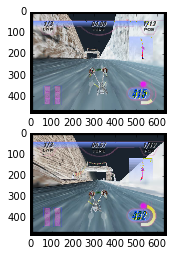

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
print frames.shape
plt.subplot(211)
plt.imshow(frames[100,:,:,:])
plt.subplot(212)
plt.imshow(frames[115,:,:,:])

Obtain VGG_S dataset:
--------


``!wget https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg_cnn_s.pkl`` <-- already run, so removing from notebook for now.

Data Transformation and Preparation functions:
----

(200, 224, 224, 3)
(200, 3, 224, 224)


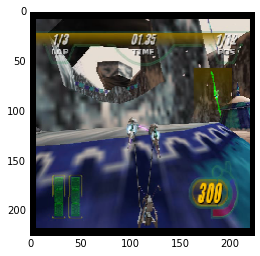

In [4]:
import io
import scipy.misc

def rescale_img(X):
    N,H,W,C = X.shape;
    XOut = np.zeros((N,224,224,C), dtype=np.uint8)
    for i in range(N):
        XOut[i,:,:,:] = scipy.misc.imresize(X[i,:,:,:], (224,224), interp="nearest")
    #im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert to BGR
    #im = im[::-1, :, :]

    return XOut;

framesResized = rescale_img(frames);
plt.imshow(framesResized[43,:,:,:])
# print framesResized[43,224/2,224/2,:]
# print frames[43,240,320,:]
# plt.imshow(frames[43,:,:,:])

# Swap the axes around for frames:
print framesResized.shape
framesResized = framesResized.swapaxes(1,2).swapaxes(1,3)
print framesResized.shape

## Importing Model

In [5]:
import lasagne
from lasagne.layers import InputLayer, DenseLayer, DropoutLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import MaxPool2DLayer as PoolLayer
from lasagne.layers import LocalResponseNormalization2DLayer as NormLayer
from lasagne.utils import floatX

Using gpu device 0: GeForce GTX 780 (CNMeM is disabled)


In [23]:
def makeNeuralNet():
    net = {}
    net['input'] = InputLayer((None, 3, 224, 224))
    net['conv1'] = ConvLayer(net['input'], num_filters=96, filter_size=7, stride=2)
    net['norm1'] = NormLayer(net['conv1'], alpha=0.0001) # caffe has alpha = alpha * pool_size
    net['pool1'] = PoolLayer(net['norm1'], pool_size=3, stride=3, ignore_border=False)
    net['conv2'] = ConvLayer(net['pool1'], num_filters=256, filter_size=5)
    net['pool2'] = PoolLayer(net['conv2'], pool_size=2, stride=2, ignore_border=False)
    net['conv3'] = ConvLayer(net['pool2'], num_filters=512, filter_size=3, pad=1)
    net['conv4'] = ConvLayer(net['conv3'], num_filters=512, filter_size=3, pad=1)
    net['conv5'] = ConvLayer(net['conv4'], num_filters=512, filter_size=3, pad=1)
    net['pool5'] = PoolLayer(net['conv5'], pool_size=3, stride=3, ignore_border=False)
    net['fc6'] = DenseLayer(net['pool5'], num_units=4096)
    net['drop6'] = DropoutLayer(net['fc6'], p=0.5)
    net['fc7'] = DenseLayer(net['drop6'], num_units=4096)
    net['drop7'] = DropoutLayer(net['fc7'], p=0.5)
    net['fc8'] = DenseLayer(net['drop7'], num_units=1000, nonlinearity=lasagne.nonlinearities.softmax)
    output_layer_vgg = net['fc8']
    net['_fc7'] = DenseLayer(net['drop6'], num_units=4096)
    net['_drop7'] = DropoutLayer(net['_fc7'], p=0.5)
    net['_fc8out'] = DenseLayer(net['_drop7'], num_units=6, nonlinearity=lasagne.nonlinearities.softmax)
    output_layer_driver = net['_fc8out']
    return output_layer_vgg, output_layer_driver
    

In [25]:
import pickle
import theano.tensor as T
import theano

NUM_EPOCHS = 500
BATCH_SIZE = 100
LEARNING_RATE = 0.001


model = pickle.load(open('vgg_cnn_s.pkl'))
CLASSES = model['synset words']
MEAN_IMAGE = model['mean image']

vgg,driver = makeNeuralNet()
lasagne.layers.set_all_param_values(vgg, model['values'])
# Load VGG CNN S into the vgg net.

X = T.tensor4()
y = T.ivector()

# training output
output_train = lasagne.layers.get_output(driver, X, deterministic=False)
# evaluation output. Also includes output of transform for plotting
output_eval = lasagne.layers.get_output(driver, X, deterministic=True)
model_params = lasagne.layers.get_all_params(driver, trainable=True)

sh_lr = theano.shared(lasagne.utils.floatX(LEARNING_RATE))
cost = T.mean(T.nnet.categorical_crossentropy(output_train, y))
updates = lasagne.updates.adam(cost, model_params, learning_rate=sh_lr)

trainFn = theano.function([X, y], [cost, output_train], updates=updates)
evalFn = theano.function([X], [output_eval])
# plt.imshow(np.swapaxes(MEAN_IMAGE,0,2).swapaxes(1,0))

#plt.imshow(MEAN_IMAGE)

In [26]:
def train_epoch(X, y):
    num_samples = X.shape[0]
    num_batches = int(np.ceil(num_samples / float(BATCH_SIZE)))
    costs = []
    correct = 0
    for i in range(num_batches):
        idx = range(i*BATCH_SIZE, np.minimum((i+1)*BATCH_SIZE, num_samples))
        X_batch = X[idx]
        y_batch = y[idx]
        cost_batch, output_train = trainFn(X_batch, y_batch)
        costs += [cost_batch]
        preds = np.argmax(output_train, axis=-1)
        correct += np.sum(y_batch == preds)

    return np.mean(costs), correct / float(num_samples)


def eval_epoch(X, y):
    output_eval, transform_eval = evalFn(X)
    preds = np.argmax(output_eval, axis=-1)
    acc = np.mean(preds == y)
    return acc, transform_eval

In [27]:
framesResized = framesResized - MEAN_IMAGE

In [28]:
%run 'InputProcessor.ipynb'

{128: 0, 4096: 1, 83886080: 4, 5242880: 3, 11534336: 2, 184549376: 5}


In [29]:
y = fileToNPArray('inputtest.txt')
print y[0]

Input file conversion complete.
[0 0 0 0 0 0]


In [16]:
valid_accs, train_accs, test_accs = [], [], []
try:
    for n in range(NUM_EPOCHS):
        train_cost, train_acc = train_epoch(data['X_train'], data['y_train'])
        valid_acc, valid_trainsform = eval_epoch(data['X_valid'], data['y_valid'])
        test_acc, test_transform = eval_epoch(data['X_test'], data['y_test'])
        valid_accs += [valid_acc]
        test_accs += [test_acc]
        train_accs += [train_acc]

        if (n+1) % 20 == 0:
            new_lr = sh_lr.get_value() * 0.7
            print "New LR:", new_lr
            sh_lr.set_value(lasagne.utils.floatX(new_lr))

        print "Epoch {0}: Train cost {1}, Train acc {2}, val acc {3}, test acc {4}".format(
                n, train_cost, train_acc, valid_acc, test_acc)
except KeyboardInterrupt:
    pass

In [17]:
print prob

[[  2.49421443e-08   7.21240867e-05   6.68767734e-06 ...,   1.23689006e-07
    3.64611624e-05   1.21628931e-04]
 [  4.86978067e-08   7.78515096e-05   7.30765350e-06 ...,   1.36835425e-07
    4.37474737e-05   1.81463460e-04]
 [  1.27495472e-08   5.93719342e-05   2.80859081e-06 ...,   2.99046476e-08
    2.53138642e-05   1.18017779e-04]
 ..., 
 [  5.30252237e-07   1.21250532e-05   2.86507329e-05 ...,   3.01014694e-07
    1.11485933e-04   2.33726023e-04]
 [  2.23439869e-07   1.26377736e-05   9.83800965e-06 ...,   8.60128964e-08
    3.33265161e-05   1.28696644e-04]
 [  2.89268076e-08   3.66161203e-06   1.37695588e-06 ...,   2.83930763e-08
    7.44135377e-06   8.78542196e-05]]
